In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
plt.style.use('seaborn') #стиль отрисовки seaborn
%matplotlib inline

In [2]:
water_data = pd.read_csv('../Data/water_potability.csv')
water_data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [3]:
water_data['ph'] = water_data['ph'].fillna(water_data.groupby('Potability')['ph'].transform('median'))
water_data['Sulfate'] = water_data['Sulfate'].fillna(water_data.groupby('Potability')['Sulfate'].transform('median'))
water_data['Trihalomethanes'] = water_data['Trihalomethanes'].fillna(water_data.groupby('Potability')['Trihalomethanes'].transform('median'))

In [4]:
X = water_data.drop('Potability', axis=1)
y = water_data['Potability']
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X,y,stratify=y,test_size=0.2, random_state=42)

In [5]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X,y,stratify=y,test_size=0.2, random_state=42)

In [6]:
model_bad = tree.DecisionTreeClassifier(
    criterion='entropy',
    class_weight='balanced',
    random_state=42
)
model_bad.fit(X_train,y_train)
y_valid_pred = model_bad.predict(X_valid)
y_train_pred = model_bad.predict(X_train)
#Выводим значения метрик для тренировочной выборки
print('Train F1 score: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
#Выводим значения метрик для валидационной выборки
print('Valid F1 score: {:.2f}'.format(metrics.f1_score(y_valid, y_valid_pred)))

Train F1 score: 1.00
Valid F1 score: 0.67


Это типичная картина переобучения: модель дерева решений полностью адаптировалась под обучающий набор данных, но не нашла общих закономерностей, поэтому результаты на контроле оставляют желать лучшего.


Проверим гипотезу о наличии переобучения у нашего дерева с помощью кросс-валидации k-fold. Организуем стратифицированную кросс-валидацию на пяти фолдах. На каждом шаге кросс-валидации будем вычислять метрику  на тренировочных и валидационных фолдах.

In [7]:
skf = model_selection.StratifiedKFold(n_splits=5)
cv_metrics = model_selection.cross_validate(
    estimator=model_bad,
    X=X,
    y=y,
    cv=skf,
    scoring='f1',
    return_train_score=True
)
cv_metrics

{'fit_time': array([0.02493215, 0.02396441, 0.02593017, 0.02393627, 0.02393603]),
 'score_time': array([0.00199461, 0.00100446, 0.00199461, 0.00199437, 0.00199485]),
 'test_score': array([0.61445783, 0.68421053, 0.62332696, 0.63276836, 0.70119522]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [8]:
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean f1: 1.00
Valid k-fold mean f1: 0.65


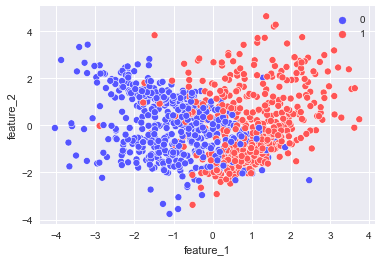

In [9]:
from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=1000, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    n_clusters_per_class=2, #количество кластеров внутри класса
    random_state=1 #генератор случайных чисел
)
X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)
sns.scatterplot(x=X['feature_1'], y=X['feature_2'], hue=y, palette='seismic');

In [10]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X,y,test_size=0.3,stratify=y,random_state=42)
model = tree.DecisionTreeClassifier(
    max_depth=10
)
model.fit(X_train,y_train)
y_valid_pred = model.predict(X_valid)
y_train_pred = model.predict(X_train)
print(metrics.classification_report(y_train, y_train_pred))
#Выводим значения метрик для валидационной выборки
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       349
           1       0.97      0.98      0.98       351

    accuracy                           0.98       700
   macro avg       0.98      0.98      0.98       700
weighted avg       0.98      0.98      0.98       700

              precision    recall  f1-score   support

           0       0.84      0.79      0.82       150
           1       0.80      0.85      0.82       150

    accuracy                           0.82       300
   macro avg       0.82      0.82      0.82       300
weighted avg       0.82      0.82      0.82       300



In [11]:
print('Current depth:', model_bad.get_depth())

Current depth: 27


In [12]:
X = water_data.drop('Potability', axis=1)
y = water_data['Potability']
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X,y,stratify=y,test_size=0.2, random_state=42)

In [13]:
model = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=7,
    random_state=42,
    class_weight='balanced'
)
skf = model_selection.StratifiedKFold(n_splits=5)

cv_metrics = model_selection.cross_validate(
    estimator=model,
    X=X,
    y=y,
    cv=skf,
    scoring='f1',
    return_train_score=True
)
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean f1: 0.75
Valid k-fold mean f1: 0.66


In [14]:
model = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=7,
    min_samples_leaf=5,
    random_state=42,
    class_weight='balanced'
)
skf = model_selection.StratifiedKFold(n_splits=5)

cv_metrics = model_selection.cross_validate(
    estimator=model,
    X=X,
    y=y,
    cv=skf,
    scoring='f1',
    return_train_score=True
)
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean f1: 0.74
Valid k-fold mean f1: 0.66


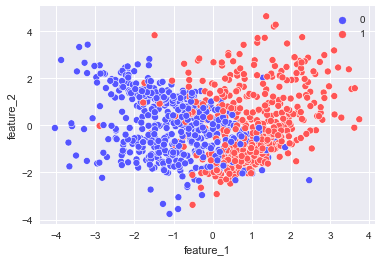

In [15]:
from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=1000, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    n_clusters_per_class=2, #количество кластеров внутри класса
    random_state=1 #генератор случайных чисел
)
X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)
sns.scatterplot(x=X['feature_1'], y=X['feature_2'], hue=y, palette='seismic');

In [16]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)
model = tree.DecisionTreeClassifier(
    max_depth=3
)
model.fit(X_train,y_train)
y_valid_pred = model.predict(X_valid)
y_train_pred = model.predict(X_train)
print(metrics.classification_report(y_train, y_train_pred))
#Выводим значения метрик для валидационной выборки
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87       399
           1       0.86      0.90      0.88       401

    accuracy                           0.88       800
   macro avg       0.88      0.88      0.88       800
weighted avg       0.88      0.88      0.88       800

              precision    recall  f1-score   support

           0       0.88      0.81      0.84       100
           1       0.82      0.89      0.86       100

    accuracy                           0.85       200
   macro avg       0.85      0.85      0.85       200
weighted avg       0.85      0.85      0.85       200



# Построение кривой обучения
/

In [17]:
model = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=7,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42
)
skf = model_selection.StratifiedKFold(n_splits=5)
train_sizes, train_scores, valid_scores = model_selection.learning_curve(
    estimator=model,
    X=X,
    y=y,
    cv=skf,
    scoring='f1'
)
print('Train sizes: \n', train_sizes)
print('Train scores: \n', train_scores)
print('Valid scores: \n', valid_scores)

Train sizes: 
 [ 80 260 440 620 800]
Train scores: 
 [[0.91489362 0.89473684 0.89473684 0.89473684 0.89473684]
 [0.89962825 0.91385768 0.91512915 0.91512915 0.91512915]
 [0.90153173 0.89519651 0.91938998 0.91416309 0.91416309]
 [0.90542636 0.90734824 0.92209857 0.90909091 0.9057187 ]
 [0.90794451 0.90012642 0.90813648 0.9041769  0.9081761 ]]
Valid scores: 
 [[0.78448276 0.77714286 0.75268817 0.8342246  0.83597884]
 [0.79069767 0.8172043  0.82352941 0.85436893 0.83902439]
 [0.87254902 0.82291667 0.81730769 0.85436893 0.85294118]
 [0.84210526 0.82795699 0.83168317 0.8195122  0.86138614]
 [0.86567164 0.87046632 0.82051282 0.83       0.86294416]]


In [18]:
train_scores_mean = np.mean(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
print('Train k-fold f1 scores',  train_scores_mean)
print('Valid k-fold f1 scores',  valid_scores_mean)

Train k-fold f1 scores [0.8987682  0.91177468 0.90888888 0.90993656 0.90571208]
Valid k-fold f1 scores [0.79690344 0.82496494 0.8440167  0.83652875 0.84991899]


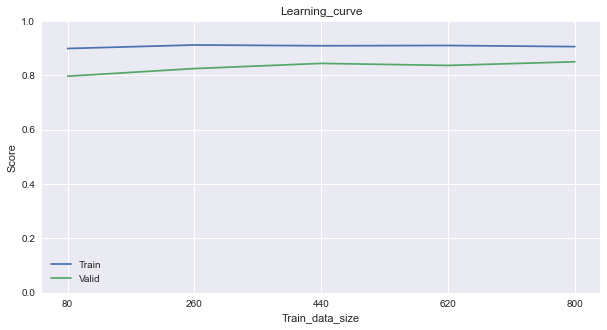

In [19]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(train_sizes,train_scores_mean,label='Train')
ax.plot(train_sizes, valid_scores_mean, label='Valid')
ax.set_title('Learning_curve')
ax.set_xlabel('Train_data_size')
ax.set_ylabel('Score')
ax.xaxis.set_ticks(train_sizes)
ax.set_ylim(0, 1)
ax.legend()